# NYC Taxi Data Analysis - EDA

This is the first notebook in the series of data analysis using Spark on NYC Taxi Dataset

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC Taxi Data Exploration") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 19:01:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/20 19:01:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Loading the Data

In [3]:
NYC_TAXI_DATA = "../../data/raw/train.csv"

df = spark.read.csv(NYC_TAXI_DATA, inferSchema=True, header=True)


## View Basic Information

Show the first few rows of the DataFrame to get a feel for the data:

In [4]:
df.show(5)


+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:10:48|    

Print the schema to understand the data types and columns:

In [5]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



## Summary Statistics

In [6]:
df.describe().show()

24/05/20 19:05:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+
|summary|       id|          vendor_id|   passenger_count|   pickup_longitude|     pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|     trip_duration|
+-------+---------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+
|  count|  1458644|            1458644|           1458644|            1458644|             1458644|            1458644|            1458644|           1458644|           1458644|
|   mean|     NULL| 1.5349502688798637|1.6645295219395548| -73.97348630489282|  40.750920908391734|  -73.9734159469458|   40.7517995149002|              NULL| 959.4922729603659|
| stddev|     NULL|0.49877715390740074| 1.314242167823115|0.07090185842270368|0.032881186257633095|0.070643268

## Other EDA steps

### Check for Missing Values

Count missing or null values in each column:

In [8]:
from pyspark.sql.functions import col, count, when

# Check for missing values in each column
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



### Unique Counts
For categorical and string columns like `vendor_id` and `store_and_fwd_flag`, check the number of unique values and see the distribution of each category.

In [9]:
from pyspark.sql.functions import desc

# Count unique values in categorical columns
df.groupBy('vendor_id').count().orderBy(desc('count')).show()
df.groupBy('store_and_fwd_flag').count().orderBy(desc('count')).show()

+---------+------+
|vendor_id| count|
+---------+------+
|        2|780302|
|        1|678342|
+---------+------+



+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 N|1450599|
|                 Y|   8045|
+------------------+-------+



### Date and Time Analysis
Since `pickup_datetime` and `dropoff_datetime` are crucial for understanding temporal patterns, we should extract more granular time parts from these timestamps.

In [10]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, dayofweek

# Extracting time parts
df = df.withColumn("pickup_dayofweek", dayofweek("pickup_datetime")) \
       .withColumn("pickup_hour", hour("pickup_datetime")) \
       .withColumn("pickup_month", month("pickup_datetime")) \
       .withColumn("pickup_year", year("pickup_datetime"))

# Analyze trips by day of week or hour
df.groupBy("pickup_dayofweek").count().orderBy("pickup_dayofweek").show()
df.groupBy("pickup_hour").count().orderBy("pickup_hour").show()


+----------------+------+
|pickup_dayofweek| count|
+----------------+------+
|               1|195366|
|               2|187418|
|               3|202749|
|               4|210136|
|               5|218574|
|               6|223533|
|               7|220868|
+----------------+------+

+-----------+-----+
|pickup_hour|count|
+-----------+-----+
|          0|53248|
|          1|38571|
|          2|27637|
|          3|21230|
|          4|15792|
|          5|15002|
|          6|33248|
|          7|55600|
|          8|67053|
|          9|67663|
|         10|65437|
|         11|68476|
|         12|71873|
|         13|71473|
|         14|74292|
|         15|71811|
|         16|64313|
|         17|76483|
|         18|90600|
|         19|90308|
+-----------+-----+
only showing top 20 rows



### Correlation Analysis
Check for correlations between numerical variables, particularly between `trip_duration`, `passenger_count`, and geographical coordinates.

In [11]:
# Correlations
df.stat.corr('trip_duration', 'passenger_count')
df.stat.corr('pickup_longitude', 'pickup_latitude')


0.02256831201328893

### Explore Geographical Data

In [12]:
# Histogram of coordinates to identify clusters or outliers
df.select("pickup_longitude", "pickup_latitude").describe().show()


+-------+-------------------+--------------------+
|summary|   pickup_longitude|     pickup_latitude|
+-------+-------------------+--------------------+
|  count|            1458644|             1458644|
|   mean| -73.97348630489282|  40.750920908391734|
| stddev|0.07090185842270368|0.032881186257633095|
|    min|-121.93334197998047|   34.35969543457031|
|    max| -61.33552932739258|   51.88108444213867|
+-------+-------------------+--------------------+



### Investigate Outliers and Anomalies

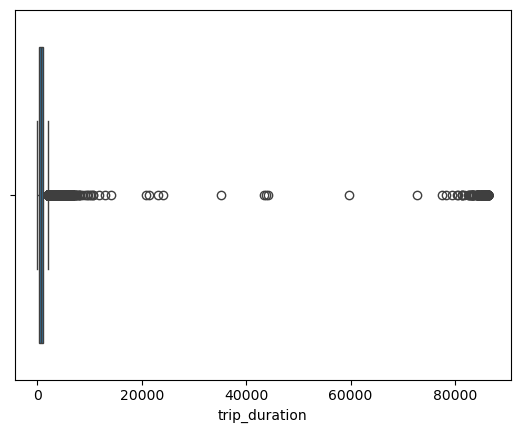

In [14]:
# Box plots can be plotted after converting to Pandas DataFrame for visualization
import seaborn as sns
import matplotlib.pyplot as plt

sampled_pd_df = df.sample(fraction=0.1).toPandas()
sns.boxplot(x=sampled_pd_df['trip_duration'])
plt.show()


## Feature Engineering

In this step, we consider creating new features that might be useful for further analysis or predictive modeling.

### Distance Calculation

Calculating the trip distance in kilometers based on geographical coordinates which gonna be useful for multiple analysis.

In [17]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import DoubleType
import pandas as pd
import numpy as np

@pandas_udf(DoubleType())
def calculate_distance_pd(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dLat = lat2 - lat1
    dLon = lon2 - lon1

    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = 6371 * c  # Earth radius in kilometers
    return d

# Apply the Pandas UDF
df = df.withColumn("trip_distance_km", calculate_distance_pd("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"))


In [18]:
# Show the result
df.select("trip_distance_km").show()

+------------------+
|  trip_distance_km|
+------------------+
|1.4985207796469109|
|1.8055071687958897|
| 6.385098495252495|
|1.4854984227709385|
|1.1885884593338851|
| 1.098942459305554|
|1.3262785770590748|
| 5.714980630789906|
|1.3103532828841316|
| 5.121161562140774|
| 3.806139394875776|
|3.7730959384723497|
| 1.859483020230105|
|0.9916848505443578|
| 6.382835756275532|
|0.6565780261385659|
| 3.428085961968358|
| 2.538671818029313|
| 4.605201075572819|
|1.3032712172360177|
+------------------+
only showing top 20 rows



## Persisting transformations and features

In [30]:
TRAIN_PROCESSED = "../../data/processed/train_processed.parquet"

df.write.format("parquet").mode("overwrite").save(TRAIN_PROCESSED)

24/05/20 21:22:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


### NOTE: Read the data back

In [31]:
df_save = spark.read.parquet(TRAIN_PROCESSED)

In [32]:
df_save.show()

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+----------------+-----------+------------+-----------+------------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|pickup_dayofweek|pickup_hour|pickup_month|pickup_year|  trip_distance_km|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+----------------+-----------+------------+-----------+------------------+
|id1090265|        1|2016-02-09 21:30:46|2016-02-09 21:34:40|              1| -74.0031967163086|40.727230072021484|-73.99812316894531|40.735618591308594|                 N|          234|               3|         21|     

In [34]:

# Shut down the current running session after using
spark.stop()